In [ ]:
import torch 
import itertools
from api.sd import *
from api.lora import *
from api.dataset import *
import bitsandbytes as bnb
from accelerate import Accelerator
from torch.utils.data import DataLoader
from diffusers.optimization import get_scheduler
from diffusers import StableDiffusionPipeline, DiffusionPipeline

if torch.cuda.is_available(): torch.cuda.empty_cache()

In [2]:
LR = 1e-4
EPOCHS = 100
LORA_RANK = 4
GRAD_AC_STEPS = 1
ADAM_EPSILON = 1e-8
BETAS = (0.9, 0.999)
LR__WARMUP_STEPS = 100
MIXED_PRECISION = None
ADAM_WEIGHT_DECAY = 1e-2


In [ ]:
accelerator = Accelerator(
    mixed_precision=MIXED_PRECISION,
    gradient_accumulation_steps=GRAD_AC_STEPS,
)

sd = SD()
sd.to(accelerator.device)

unet_lora_params, _ = inject_trainable_lora(sd.unet, r=LORA_RANK)
params_to_optimize = itertools.chain(*unet_lora_params)
optimizer = bnb.optim.AdamW8bit(params_to_optimize,
    lr=LR,
    betas=BETAS,
    eps=ADAM_EPSILON,
    weight_decay=ADAM_WEIGHT_DECAY,
)

In [4]:
BATCH_SIZE = 1
NUM_WORKERS = 1

PROMPT = ""
IMG_DIR_PATH = f"{BASE_DIR}/laura"

train_dataset = CustomDataset(IMG_DIR_PATH, PROMPT)
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=NUM_WORKERS)

In [5]:
TRAIN_STEPS = EPOCHS * len(train_data_loader) // GRAD_AC_STEPS

lr_scheduler = get_scheduler("constant",
    optimizer=optimizer,
    num_warmup_steps=LR__WARMUP_STEPS * GRAD_AC_STEPS,
    num_training_steps=EPOCHS * len(train_data_loader)
)

progress_bar = tqdm(range(TRAIN_STEPS), desc="Steps")
for _ in range(EPOCHS):
    sd.unet.train()
    train_epoch(sd, train_data_loader, accelerator, optimizer, lr_scheduler, progress_bar)

accelerator.wait_for_everyone()

Steps: 100%|██████████| 1500/1500 [07:14<00:00,  3.54it/s, loss=0.0272, lr=0.0001] 

In [6]:
pipeline = StableDiffusionPipeline.from_pretrained(
    sd.model_id,
    unet=accelerator.unwrap_model(sd.unet),
    text_encoder=accelerator.unwrap_model(sd.text_encoder),
)
loras = {
    "unet": (pipeline.unet, {"CrossAttention", "Attention", "GEGLU"})
} 

save_lora_weight(pipeline.unet, f"{BASE_DIR}/saved/lora_weight.pt")
save_safeloras(loras, f"{BASE_DIR}/saved/lora_weight.safetensors")
accelerator.end_training()

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 20.97it/s]

Saving weights to /home/ec2-user/story_fave/backend/saved/lora_weight.safetensors


In [7]:
pipe = StableDiffusionPipeline.from_pretrained(sd.model_id, torch_dtype=torch.float16).to("cuda")

monkeypatch_or_replace_lora(pipe.unet, torch.load(f"{BASE_DIR}/saved/lora_weight.pt"))


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  4.22it/s]
/tmp/ipykernel_7446/461638855.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  monkeypatch_o

In [8]:
pipe.safety_checker = None

100%|██████████| 50/50 [00:03<00:00, 14.86it/s]


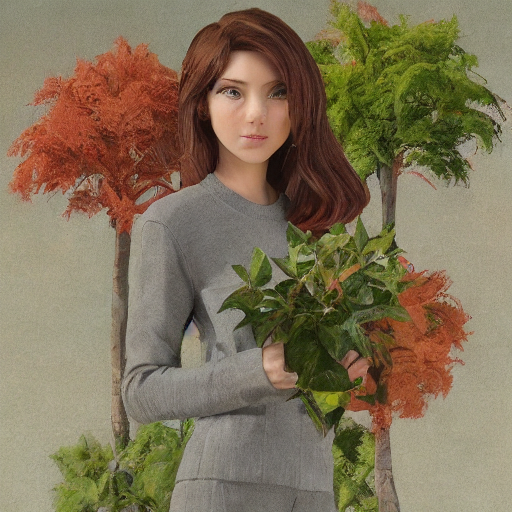

In [32]:
GUIDANCE = 2
LORA_SCALE_UNET = 0.8
INFERENCE_PROMPT = '<s1><s2> is in the center, behind her is a beautiful scenary of green lusheous plants and trees and the sun is shining. She is smiling, impressionism' 

tune_lora_scale(pipe.unet, LORA_SCALE_UNET)
image = pipe(INFERENCE_PROMPT, num_inference_steps=50, guidance_scale=GUIDANCE).images[0]
image